# Coronagraph inpainting model

## Data downloading and preprocessing

!python3 data.py

In [1]:
from utils import get_default_device
device = get_default_device()
print(device)

cuda


In [2]:
import torch
torch.cuda.empty_cache()

## Creating dataset

In [3]:
batch_size = 1

In [4]:
from torch.utils.data import random_split, DataLoader
from utils import DeviceDataLoader
from data import CoronagraphDataset, CrossDataset

dataset = CoronagraphDataset('c3')
# 0.8 - 0.2
train_len = round(0.8*len(dataset))
val_len = len(dataset) - train_len

#random split
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_dl = DeviceDataLoader(DataLoader(train_ds, batch_size, True, num_workers = 4, pin_memory=True), device)
val_dl = DeviceDataLoader(DataLoader(val_ds, batch_size, True, num_workers = 4, pin_memory=True), device)

/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
import torch
from utils import to_device
sample_tensor = (torch.randn(1,1,1024,1024).to(device), torch.ones(1,1,1024,1024).to(device))

In [6]:
from model import SmallUNet
from loss import NewInpaintingLoss

model = to_device(SmallUNet('Cross_model', NewInpaintingLoss([6, 6, 0.5, 1.2, 1.8, 0.7]), 2), device)

In [7]:
import torch.nn.functional as F
model.spe_act = lambda x: F.sigmoid(x)

Validation - Epoch: 0: 100%|██████████| 329/329 [00:40<00:00,  8.11it/s]


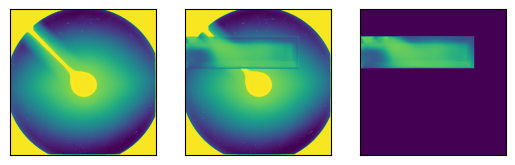

Validation - Epoch: 1: 100%|██████████| 329/329 [00:41<00:00,  8.01it/s]


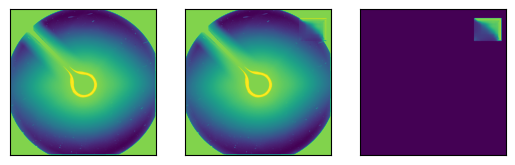

Training - Epoch: 2:  70%|██████▉   | 917/1316 [04:07<01:50,  3.62it/s]

In [8]:
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam, SGD, RMSprop
model.fit(
    train_dl,
    val_dl,
    epochs = 25,
    lr = 2e-4,
    batch_size = batch_size,
    weight_decay = 0,
    grad_clip = False,
    opt_func = Adam,
    lr_sched = OneCycleLR,
    saving_div = 5,
    graph = True,
    sample_input = sample_tensor
)